Métodos directos no derivativos
===

* 30:00 min | Última modificación: Mayo 19, 2021 | [YouTube]

In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np

In [2]:
#
# Función de Rosenbrock
#
def fn(x):
    return 100 * (x[0] ** 2 - x[1]) ** 2 + (1 - x[0]) ** 2

## Clase base

In [3]:
class BaseOptimizer:
    def __init__(self, fn):
        self.fn = fn
        self.x_opt = None
        self.fn_opt = None
        self.n_dim = None
        self.history = {
            "fn_opt": [],
            "x_opt": [],
            "x": [],
            "fn_x": [],
        }

    def record(self, x, fn_x):
        self.history["x"].append(x)
        self.history["fn_x"].append(fn_x)

    def eval(self, x):
        fn_x = self.fn(x)
        if self.fn_opt is None or fn_x < self.fn_opt:
            self.fn_opt = fn_x
            self.x_opt = x
            self.n_dim = len(x)
            self.history["x"].append(x)
            self.history["fn_x"].append(fn_x)
            self.history["x_opt"].append(x)
            self.history["fn_opt"].append(fn_x)
        return fn_x

    def random_direction(self):
        w = np.random.uniform(low=-1, high=+1, size=self.n_dim)
        m = np.linalg.norm(w)
        return w / m

## Búsqueda por coordenadas cíclicas

In [4]:
class CoordinateSearch(BaseOptimizer):
    #
    # Propueto por Fermi y Metropolis en 1952
    # Fue diseñado para solucionar sistemas
    #  complejos de ecuaciones en fisica nuclear
    #
    def __init__(self, fn, delta=0.5):
        super().__init__(fn=fn)
        self.delta = delta

    def __call__(self, x, fn_x=None):

        if fn_x is None:
            fn_x = self.eval(x)

        #
        # Busca a lo largo de cada eje hasta encontrar
        # un punto mejor
        #
        for i_coordinate in range(len(x)):

            x_left = x.copy()
            x_left[i_coordinate] = x_left[i_coordinate] - self.delta
            fn_x_left = self.eval(x_left)

            x_right = x.copy()
            x_right[i_coordinate] = x_right[i_coordinate] + self.delta
            fn_x_right = self.eval(x_right)

            if fn_x_left > fn_x and fn_x < fn_x_right:

                #
                # Encontró un punto de minima entre
                #  x_left y x_right
                #
                for n in range(20):

                    l = x_left + 0.382 * (x_right - x_left)
                    u = x_left + 0.618 * (x_right - x_left)

                    fl = self.fn(l)
                    fu = self.fn(u)

                    if fl > fu:
                        x_left = l
                    else:
                        x_right = u

                x = 0.5 * (x_left + x_right)
                fn_x = self.eval(x)

            else:

                #
                # El punto de mínima está en uno de los extremos
                #
                if fn_x_left < fn_x:
                    x = x_left
                    fn_x = fn_x_left
                if fn_x_right < fn_x:
                    x = x_right
                    fn_x = fn_x_right

        #
        # Almacena el último punto visitado
        #
        self.record(x, fn_x)

        return self.x_opt, self.fn_opt


optimizer = CoordinateSearch(
    fn=fn,
    delta=0.5,
)

#
# Punto inicial
#
x = np.asarray([-1.0, 3.5], dtype=np.float32)
fx = None

for epoch in range(20):
    x, fx = optimizer(x, fx)

optimizer.x_opt, optimizer.fn_opt

(array([-1.6880744,  2.8496103], dtype=float32), 7.225743736506537)

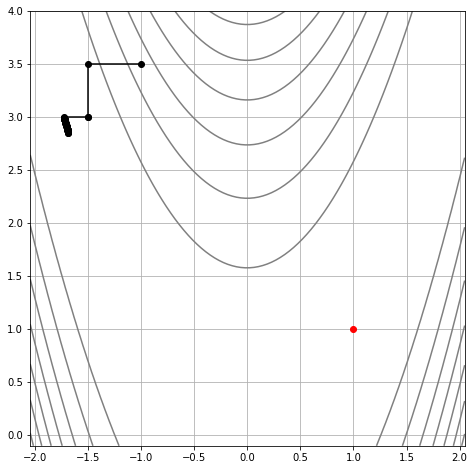

In [5]:
def plot_trayectory(optimizer):
    #
    # Función
    #
    def f(x, y):
        return 100 * (x ** 2 - y) ** 2 + (1 - x) ** 2

    #
    X = np.linspace(start=-2.048, stop=2.048, num=100)
    Y = np.linspace(start=-0.1, stop=4.0, num=100)
    X, Y = np.meshgrid(X, Y)
    Z = f(X, Y)

    #
    # Contorno
    #
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect("equal", "box")
    ax.contour(X, Y, Z, colors="gray")
    ax.grid()
    plt.plot([1], [1], "o", color="red")

    #
    # Trayectoria
    #
    hist_x = optimizer.history["x"]
    x = [point[0] for point in hist_x]
    y = [point[1] for point in hist_x]
    plt.plot(x, y, "o-", color="k")


plot_trayectory(optimizer)

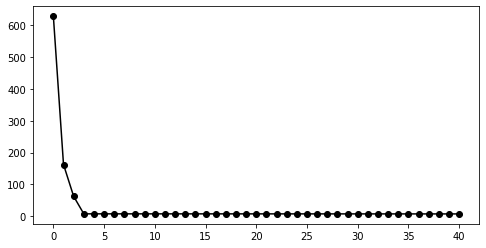

In [6]:
def plot_fn(optimizer):
    plt.figure(figsize=(8, 4))
    plt.plot(
        range(len(optimizer.history["fn_opt"])),
        optimizer.history["fn_opt"],
        "o-k",
    )
    plt.show()


plot_fn(optimizer)

## Búsqueda Local

In [7]:
class LocalSearch(BaseOptimizer):
    #
    # Desarrollada por Hooke & Jeeves en 1962. Combina
    # la búsqueda lineal con la explotación de las
    #  direcciones encontradas
    #
    def __init__(self, fn, delta0=0.5, reduction_factor=0.9):
        super().__init__(fn=fn)
        self.delta0 = delta0
        self.reduction_factor = reduction_factor
        self.delta = None

    def __call__(self, x, fn_x=None):

        if fn_x is None:
            fn_x = self.eval(x)

        if self.delta is None:
            self.delta = self.delta0

        x_base = x.copy()
        fn_x_base = fn_x

        for i_coordinate in range(len(x)):

            x_left = x.copy()
            x_left[i_coordinate] = x_left[i_coordinate] - self.delta
            fn_x_left = self.eval(x_left)

            if fn_x_left < fn_x:
                x = x_left
                fn_x = fn_x_left
            else:
                x_right = x.copy()
                x_right[i_coordinate] = x_right[i_coordinate] + self.delta
                fn_x_right = self.eval(x_right)

                if fn_x_right < fn_x:
                    x = x_right
                    fn_x = fn_x_right

        x_next = 2 * x - x_base
        fn_x_next = self.eval(x_next)

        if self.fn_opt >= fn_x_base:
            self.delta *= self.reduction_factor

        return self.x_opt, self.fn_opt


optimizer = LocalSearch(
    fn=fn,
    delta0=0.5,
    reduction_factor=0.9,
)

#
# Punto inicial
#
x = np.asarray([-1.0, 3.5], dtype=np.float32)
fx = None

for epoch in range(20):
    x, fx = optimizer(x, fx)

optimizer.x_opt, optimizer.fn_opt

(array([-1.5      ,  2.1793516], dtype=float32), 6.7491200912684235)

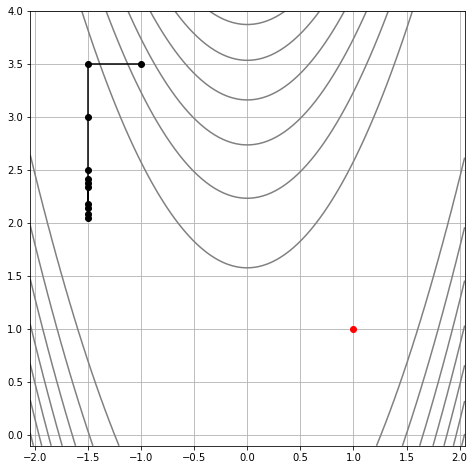

In [8]:
plot_trayectory(optimizer)

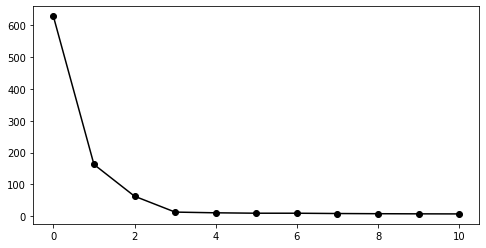

In [9]:
plot_fn(optimizer)